In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

%matplotlib inline

Let's check if PyTorch is using GPU

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
print(torch.cuda.get_device_name(0))

device: cuda:0
NVIDIA GeForce RTX 3060


## Data Exploration

The CSV file contained the house prices, the type of house asset (such as Condominium, Bungalow, etc.)

In [3]:
df = pd.read_csv("data_kaggle.csv")
print(len(df))

53883


In [4]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


## Data Cleaning (a.k.a Pre-processing)
We noticed that there are some rows are "NaN", which containing meaningless values.
Before make our hands wet, these values must be replace by mean either its mode or mean
corresponding to its location.

In [5]:
import re
import locale
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

non_decimal = re.compile(r'[^\dx]+')

df['Price'] = df['Price'].apply(lambda x: non_decimal.sub('', str(x)))
df['Price'] = df['Price'].apply(lambda x: int(x) / 1000 if x != '' else np.nan)

In [6]:
pattern = re.compile(r"[A-Za-z] : (.,?[\d.]+)[xX~]?(\d+)? sq. ft.")

def check_none(val):
    if not (val is None):
        return locale.atof(str(val))
    else:
        return 1

def format_size_col(x: str):
    m = re.search(pattern, str(x))
    if m:
        result = locale.atof(m.groups()[0]) * check_none(m.groups()[1])
        return result
    else:
        return float('nan')

df['Size'] = df['Size'].apply(lambda x: format_size_col(x))
# df['Size'] = df['Size'].apply(lambda x: np.sqrt(int(x)) if type(x) != str else float('nan'))

In [7]:
def format_room_col(x):
    return eval(str(x) if type(x) == str and x != 'Studio' else 'float("nan")')

df['Rooms'] = df['Rooms'].apply(lambda x: format_room_col(x))

In [8]:
furnishing_dict = {
    'Unfurnished': 0,
    'Partly Furnished': 1,
    'Fully Furnished': 2,
}

df['Furnishing'] = df['Furnishing'].apply(lambda x: int(furnishing_dict[x] if str(x) in furnishing_dict.keys() else 0))

In [9]:
df['Location'] = df['Location'].apply(lambda x: x.removesuffix(', Kuala Lumpur'))

In [10]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,KLCC,1250.0,3.0,3.0,2.0,Serviced Residence,1335.0,2
1,Damansara Heights,6800.0,6.0,7.0,NaN,Bungalow,6900.0,1
2,Dutamas,1030.0,3.0,4.0,2.0,Condominium (Corner),1875.0,1
3,Cheras,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Bukit Jalil,900.0,5.0,3.0,2.0,Condominium (Corner),1513.0,1


### Handling missing values

When dealing with missing data, data scientists use two common methods to solve this 
problem: imputations, or just removing the row that contains missing value.

In this project, we will just drop the missing rows. 

In [11]:
df = df.dropna().reset_index(drop=True)

In [12]:
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,KLCC,1250.0,3.0,3.0,2.0,Serviced Residence,1335.0,2
1,Dutamas,1030.0,3.0,4.0,2.0,Condominium (Corner),1875.0,1
2,Bukit Jalil,900.0,5.0,3.0,2.0,Condominium (Corner),1513.0,1
3,Taman Tun Dr Ismail,5350.0,6.0,5.0,4.0,Bungalow,7200.0,1
4,Taman Tun Dr Ismail,2600.0,5.0,4.0,4.0,Semi-detached House,3600.0,1
...,...,...,...,...,...,...,...,...
34424,Kuchai Lama,585.0,4.0,3.0,2.0,Condominium,1313.0,0
34425,KL Sentral,1400.0,4.0,3.0,2.0,Condominium (Corner),1544.0,2
34426,KL Eco City,880.0,1.0,1.0,1.0,Condominium (Corner),650.0,1
34427,Sri Hartamas,2700.0,6.0,6.0,3.0,Condominium (Corner),3973.0,1


In [13]:
df[['Rooms', 'Bathrooms', 'Car Parks']] = df[['Rooms', 'Bathrooms', 'Car Parks']].astype('float').astype('int')
#df['Location'] = df['Location'].astype('category')

In [14]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,KLCC,1250.0,3,3,2,Serviced Residence,1335.0,2
1,Dutamas,1030.0,3,4,2,Condominium (Corner),1875.0,1
2,Bukit Jalil,900.0,5,3,2,Condominium (Corner),1513.0,1
3,Taman Tun Dr Ismail,5350.0,6,5,4,Bungalow,7200.0,1
4,Taman Tun Dr Ismail,2600.0,5,4,4,Semi-detached House,3600.0,1


## Building Machine Learning Model

In [15]:
from torch.utils.data import Dataset, DataLoader
    
class HousePriceDataset(Dataset):
    def __init__(self, X, Y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        self.y = Y.copy().values.astype(np.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [16]:
from sklearn.model_selection import train_test_split

selected_col = ['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Furnishing']
df_select = df[selected_col]

y = df['Price']
X = df[['Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Furnishing']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

The data is now served well, it is time to check how many unique values they have.

In [17]:
# embedded_cols = {colname: count for colname, count in zip(df.columns, df.nunique())}
embedded_cols = {
 'Rooms': 17,
 'Bathrooms': 17,
 'Car Parks': 21,
 'Furnishing': 3
}

In [18]:
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _, n_categories in embedded_cols.items()]
embedding_sizes

[(17, 9), (17, 9), (21, 11), (3, 2)]

In [19]:
train_ds = HousePriceDataset(X_train, y_train, ['Rooms', 'Bathrooms', 'Car Parks', 'Furnishing'])

In [20]:
test_ds = HousePriceDataset(X_test, y_test, ['Rooms', 'Bathrooms', 'Car Parks', 'Furnishing'])

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [23]:
batch_size = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [24]:
class FeedForwardModel(nn.Module):
    def __init__(self, emb_sizes, n_cont) -> None:
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, size) for categories, size in emb_sizes
        ])
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)

        self.embed_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
    
    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embed_drop(x)
        x2 = self.bn1(x_cont)

        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)

        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [25]:
model = FeedForwardModel(embedding_sizes, 1)
to_device(model, device)

FeedForwardModel(
  (embeddings): ModuleList(
    (0-1): 2 x Embedding(17, 9)
    (2): Embedding(21, 11)
    (3): Embedding(3, 2)
  )
  (lin1): Linear(in_features=32, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=5, bias=True)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embed_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [26]:
def get_optimizer(model, lr = 0.001, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [27]:
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        print(output)
        loss = F.mse_loss(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

In [28]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.mse_loss(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

In [29]:
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("training loss: ", loss)
        val_loss(model, test_dl)

In [30]:
train_loop(model, epochs=8, lr=0.05, wd=0.00001)

tensor([[ 0.2531, -0.6222,  0.4165, -0.2341, -0.4215],
        [-1.0854, -0.2229,  0.9686, -0.7740, -0.3219],
        [ 0.4273,  0.0476,  0.2600,  0.0200,  0.2836],
        ...,
        [-0.1666, -0.6062,  0.2276, -0.3411,  0.5371],
        [ 0.4063, -0.2623, -0.5257, -0.9936,  0.9608],
        [-1.0045,  0.1196,  0.3086,  0.8201, -0.1769]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/tmp/ipykernel_50989/2046743760.py:9: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, y)


RuntimeError: The size of tensor a (5) must match the size of tensor b (1000) at non-singleton dimension 1

In [ ]:
scaling = MinMaxScaler()
selected_col = ['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Furnishing']

#df_select = pd.DataFrame(scaling.fit_transform(df[selected_col]), columns=selected_col)
df_select = df[selected_col]

## Building model

In [ ]:
#plt.figure(figsize  = (2, 2))
#sb.pairplot(df_select)
#plt.savefig('./images/pairplot.png')

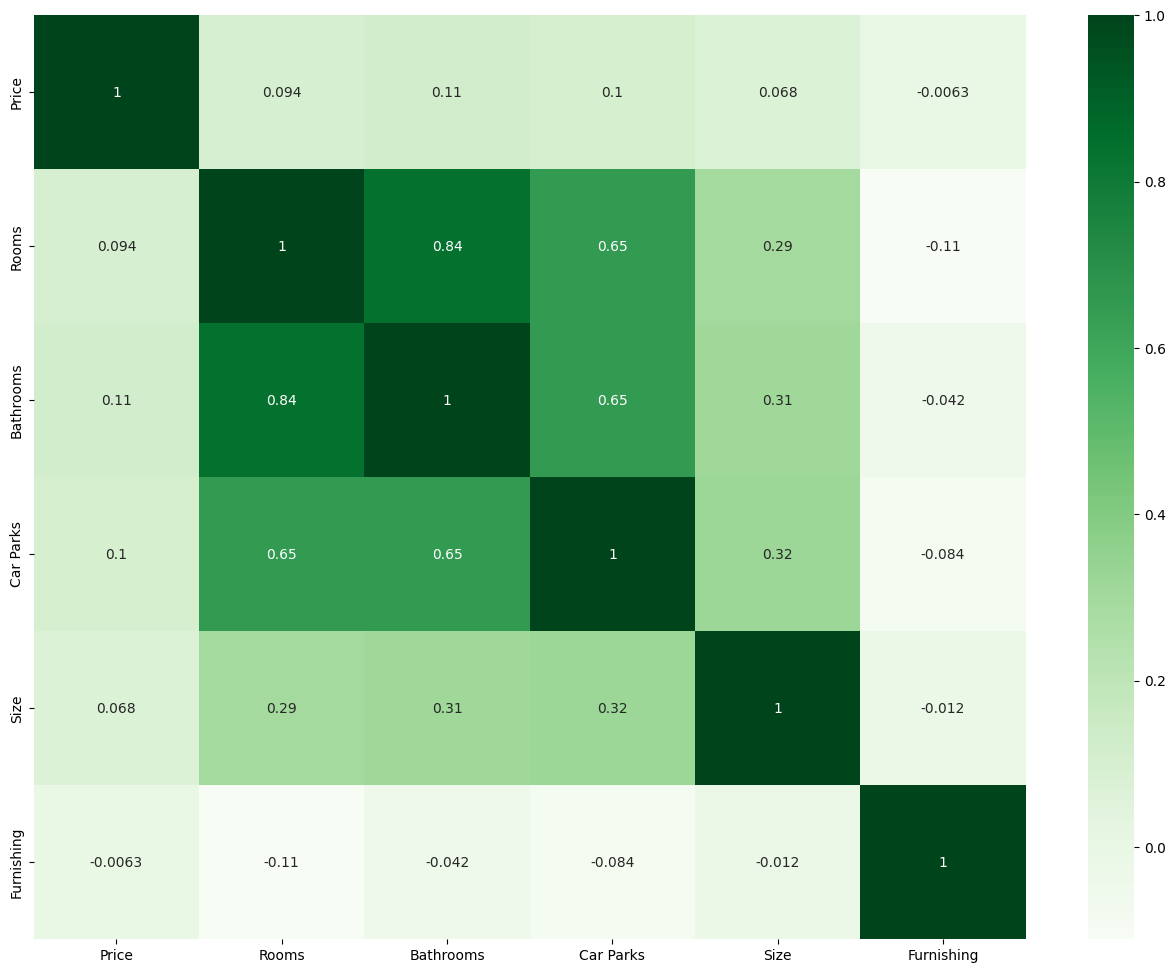

In [ ]:
plt.figure(figsize = (16, 12))
sb.heatmap(df_select.corr(), cmap = 'Greens', annot = True)
plt.savefig('./images/features_correlation.png')

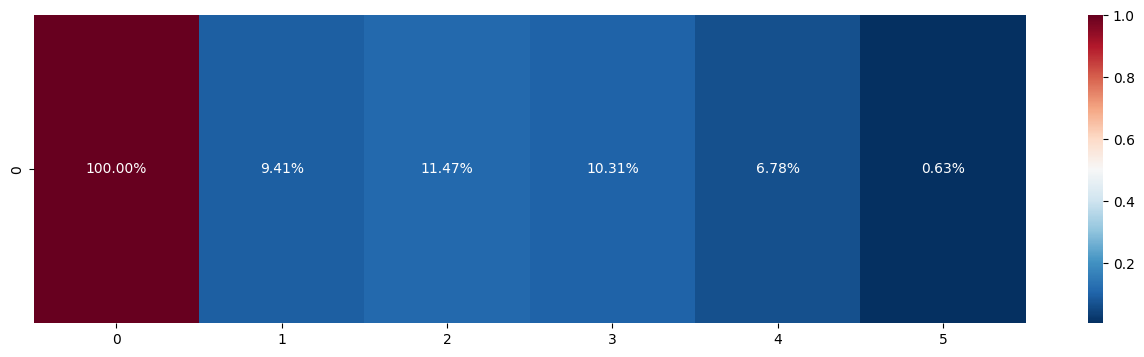

In [ ]:
# TODO : Visualizing correlation of features with prediction column `MEDV`

corr_with_price = df_select.corrwith(df_select['Price'])

plt.figure(figsize = (16, 4))
sb.heatmap([np.abs(corr_with_price)], cmap = 'RdBu_r', annot = True, fmt = '.2%')
plt.savefig('./images/correlation_with_price.png')

The regression model is formulated as

$$
    Price = \beta_0 \> Rooms + \beta_1 \> BathRooms + \beta_2 \> CarParks + \beta_3 \> Size
$$

In [ ]:
from sklearn.model_selection import train_test_split

y = df_select['Price'].values
X = df_select[['Rooms', 'Bathrooms', 'Car Parks', 'Size']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
rfr = RandomForestRegressor(max_depth = 13, random_state = 68)
rfr.fit(X_train, y_train)


print('Training Score : ', rfr.score(X_train, y_train))
print('Testing Score  : ', rfr.score(X_test, y_test))

print('R2 Score : ', r2_score(y_test, rfr.predict(X_test)))
print('MSE : ', mean_squared_error(y_test, rfr.predict(X_test)))

Training Score :  0.5812573420753264
Testing Score  :  0.624363740187777
R2 Score :  0.624363740187777
MSE :  1712028.205271287


In [ ]:
rfr.score(X_train,y_train)

0.5812573420753264

In [ ]:
b_init = 0
w_init = np.random.randn(3,)

In [ ]:
def compute_cost(X, y, w, b):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + np.square(f_wb_i - y[i])
    cost = cost / (2 * m)
    return cost

In [ ]:
cost = compute_cost(X_train, y_train, w_init, b_init)
cost

ValueError: shapes (4,) and (3,) not aligned: 4 (dim 0) != 3 (dim 0)

In [ ]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [ ]:
import copy
import math

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append(cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i}: Cost {J_history[-1]}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [ ]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-10
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                            compute_cost, compute_gradient, 
                                            alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration 0: Cost 97677326469080.69   
Iteration 100: Cost 96522357907436.12   
Iteration 200: Cost 96375390909971.48   
Iteration 300: Cost 96356688053594.72   
Iteration 400: Cost 96354306292816.75   
Iteration 500: Cost 96354001325753.52   
Iteration 600: Cost 96353960622334.5   
Iteration 700: Cost 96353953545404.02   
Iteration 800: Cost 96353950747312.1   
Iteration 900: Cost 96353948493690.28   
b,w found by gradient descent: 0.50,[  2.27993261   2.19074842   1.51555372 362.93244496] 
prediction: 281281.33, target value: 380000.0
prediction: 462752.11, target value: 448000.0
prediction: 424644.20, target value: 680000.0
prediction: 1684038.42, target value: 2600000.0
prediction: 417385.55, target value: 889000.0
prediction: 789030.57, target value: 1673000.0
prediction: 261683.06, target value: 630000.0
prediction: 286725.40, target value: 805000.0
prediction: 664550.81, target value: 1200000.0
prediction: 3266437.37, target value: 4500000.0
prediction: 471829.21, target value: 

AttributeError: 'LinearRegression' object has no attribute 'Lasso'

In [ ]:
linear_model.coef_

AttributeError: module 'sklearn.linear_model' has no attribute 'coef_'

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print('Training Score : ', linear_model.score(X_train, y_train))
print('Testing Score  : ', linear_model.score(X_test, y_test))

print('R2 Score : ', r2_score(y_test, linear_model.predict(X_test)))
print('MSE : ', mean_squared_error(y_test, linear_model.predict(X_test)))

AttributeError: module 'sklearn.linear_model' has no attribute 'score'

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
adtr_model = make_pipeline(MinMaxScaler(), DecisionTreeRegressor(max_depth = 4, random_state = 42))
adtr_model.fit(X_train, y_train)

print('Training Score : ', adtr_model.score(X_train, y_train))
print('Testing Score  : ', adtr_model.score(X_test, y_test))

print('R2 Score : ', r2_score(y_test, adtr_model.predict(X_test)))
print('MSE : ', mean_squared_error(y_test, adtr_model.predict(X_test)))

Training Score :  0.7605762400897832
Testing Score  :  0.4802686016186267
R2 Score :  0.4802686016186267
MSE :  2368767098359.457


## References

1. Data Source: https://www.kaggle.com/datasets/dragonduck/property-listings-in-kuala-lumpur